In [3]:
# interpolate
# regress
# sample

import numpy
import warnings

In [ ]:
class BarycentricRationalApproximant:

    def __init__(self, zj, fj, wj):
        self.zj = numpy.asarray(zj)
        self.fj = numpy.asarray(fj)
        self.wj = numpy.asarray(wj)
        assert self.zj.ndim == self.fj.ndim == self.wj.ndim == 1
        assert self.zj.size == self.fj.size == self.wj.size
        self.M = len(zj)

    def __call__(self, z):
        zj = self.zj
        fj = self.fj
        wj = self.wj
        Cd = z[:, None] - zj[None, :]
        ij, jj = numpy.nonzero(Cd == 0)
        Cd[ij, jj] = 1
        C = 1/Cd
        f = C.dot(wj*fj)/C.dot(wj)
        f[ij] = fj[jj]
        return f

    def __len__(self):
        return self.M

    @functools.cached_property
    def poles(self):
        zj = self.zj
        wj = self.wj
        B = numpy.eye(len(wj) + 1)
        B[0, 0] = 0
        E = numpy.block([
            [0, wj],
            [numpy.ones((self.M, 1)), numpy.diag(zj)]
        ])
        p = scipy.linalg.eigvals(E, B)
        return numpy.real_if_close(p[numpy.isfinite(p)])

    @functools.cached_property
    def residues(self):
        poles = self.poles
        # compute residues via formula for simple poles using L'Hôpital's rule
        # to evaluate the limit
        ## cf: https://en.wikipedia.org/wiki/Residue_(complex_analysis)#Simple_poles
        zj = self.zj
        fj = self.fj
        wj = self.wj
        C = 1/(poles[:, None] - zj[None, :])
        n = C.dot(fj*wj)
        d = (-C**2).dot(wj)
        residues = n/d
        return residues

    def polres(self):
        return self.poles, self.residues

    @classmethod
    def aaa(cls, z, f, tol=1e-13, M=None, Mmax=200):
        inf = numpy.inf
        z = numpy.asarray(z)
        f = numpy.asarray(f)
        assert z.ndim == f.ndim == 1
        assert z.size == f.size
        N = len(z)
        j = []
        e = []
        hist = []
        k = list(range(N))
        fm = f.mean()*numpy.ones(N)
        r = f - fm
        e.append(numpy.linalg.norm(r, inf))
        rtol = tol*numpy.linalg.norm(f, inf)
        hist.append({
            'j': j.copy(),
            'k': k.copy(),
            'e': e.copy(),
            'f': fm.copy(),
            'r': r.copy(),
        })
        if M is not None:
            Mmax = M
        for m in range(Mmax):
            jm = numpy.argmax(abs(r))
            j.append(jm)
            k.remove(jm)
            C = 1/(z[k, None] - z[None, j])
            A = (f[k, None] - f[None, j])*C
            _, _, Vh = numpy.linalg.svd(A)
            wj = Vh[-1, :].conj()
            wj = wj
            n = C.dot(wj*f[j])
            d = C.dot(wj)
            fm = f.copy()
            fm[k] = n/d
            r = f - fm
            e.append(numpy.linalg.norm(r, inf))
            hist.append({
                'j': j.copy(),
                'k': k.copy(),
                'e': e.copy(),
                'f': fm.copy(),
                'r': r.copy(),
            })
            if M is None and e[-1] < rtol:
                break
        else:
            if M is None:
                warnings.warn('Maximum number of iterations reached.')
        jnz = wj != 0
        wj = wj[jnz]
        j = numpy.asarray(j)
        zj = z[j[jnz]]
        fj = f[j[jnz]]
        b = cls(zj, fj, wj)
        b.j = j
        b.k = asarray(k)
        b.fit_history = hist
        return b

aaa.interp
aaa.lstsq
aaa.sample

In [10]:
import numpy

N = 200
m = 10000
M = m*int(1.5*N)

a = numpy.random.rand(M, N)
#%time s = numpy.linalg.svd(a)

In [11]:
a.nbytes

4800000000

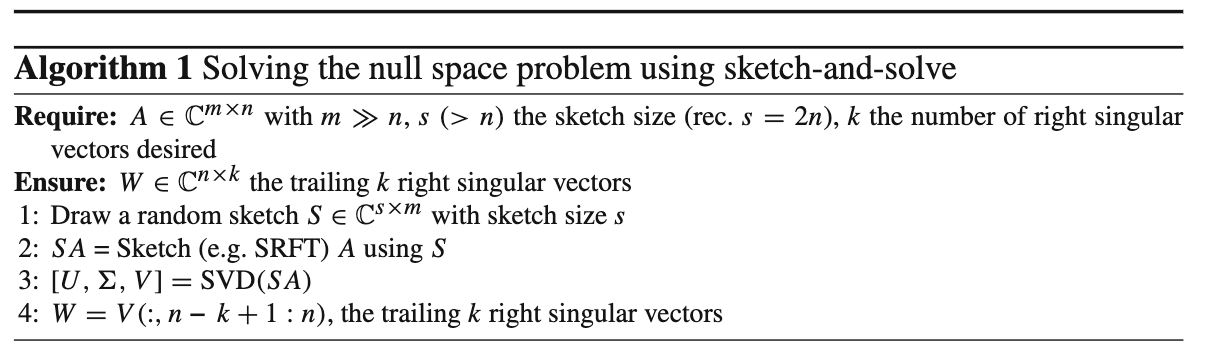

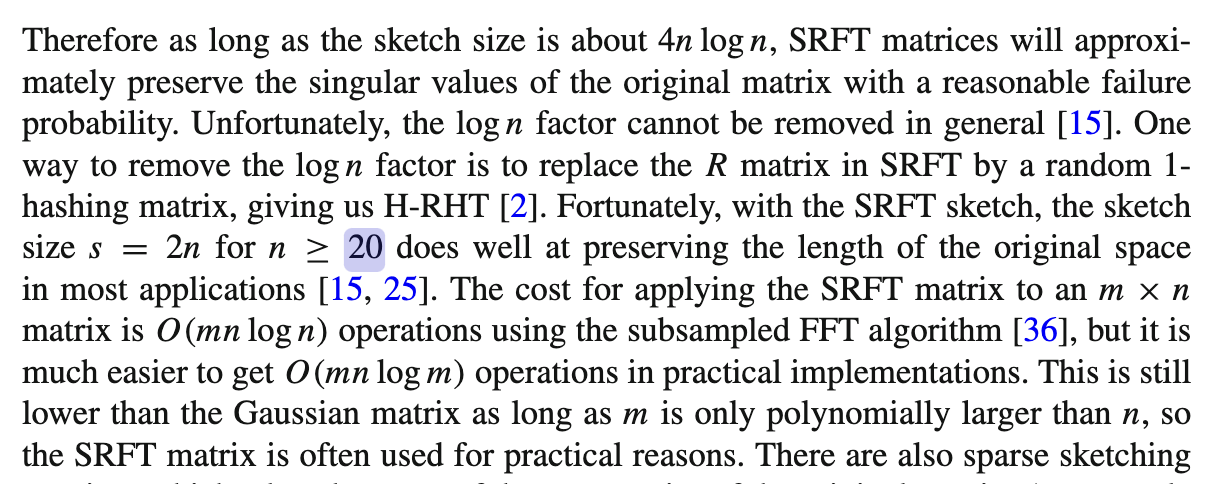